In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import warnings
warnings.filterwarnings("ignore")
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

Qui vengono importate le librerie necessarie

In [2]:
# statistical results
from statsmodels.formula.api  import ols
import statsmodels.api as sm


# visualization
import matplotlib.pyplot as plt
import pandas as pd
#%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree 
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from sklearn import svm
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

# outliers detection
from sklearn.ensemble import IsolationForest

Lo scopo di questo esercizio consiste nel combinare e mediare le previsioni sul dataset di test, partendo da comuni modelli di classificazione e regressione addestrati sul train dataset. Gli algoritmi utilizzati sono: il Support Vector Machine, il Gaussian Naive Bayes, il Decision Tree, la Random Forest, il K-Nearest Neighbors, e la Regressione Logistica. 

Per realizzare un classificatore Ensemble in grado di produrre un vettore di previsioni per il dataset di test, è necessario stimare vari modelli appartenenti alle famiglie selezionate, e selezionare quei modelli che presentano una migliore accuratezza in fase di convalida. Per fare questo è stata condotta un'ottimizzazione dei parametri più influenti. è stato anche selezionato il migliore modello per ogni tipo di classificatore

Infine, verrà sottoposto a Kaggle un vettore di previsioni (418\ \ast\ 1), i cui risultati saranno i valori medi di ogni test datapoint ottenuti considerando tutti i classificatori selezionati, e attribuendo un peso maggiore ai classificatori con la migliore accuracy in fase di convalida. Si utilizza infatti un approccio ensemble perché si tiene conto di vari classificatori.

In [3]:
#train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
#test_df = pd.read_csv('/kaggle/input/titanic/test.csv')
#train_df = pd.read_csv('C:/Users/Tommaso/Documents/Python Scripts\MACHINE LEARNING with UDACITY/Less2 p19 classification cars/titanic/train.csv')
train_df = pd.read_csv('train.csv')
#test_df = pd.read_csv('C:/Users/Tommaso/Documents/Python Scripts\MACHINE LEARNING with UDACITY/Less2 p19 classification cars/titanic/test.csv')
test_df = pd.read_csv('test.csv')

Combino i set di dati di train e di test in una sola, in modo da poter gestire contemporaneamente le features di entrambi i set di dati

In [4]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
#distance Ny Southampton 5950
#distance Ny Cherbourg 5800
#distance Ny Cogh 5210

test_df["Survived"]=np.empty(test_df.shape[0])
test_df["Survived"] = np.nan

test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,NaN
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,NaN
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,NaN
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,NaN
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,NaN
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,NaN
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,NaN
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,NaN


La riga seguente rende omogeneo l'ordine dei dataset di train e di test

In [6]:
train_df=train_df[["PassengerId","Pclass","Name","Sex","Age","SibSp","Parch","Ticket","Fare","Cabin","Embarked","Survived"]]

Combino i set di dati di train e di test in una sola, in modo da poter gestire contemporaneamente le features di entrambi i set di dati

In [7]:
all_df=[train_df,test_df]

#IT: Pulizia del codice:
    -con la riga dataset['Age'][np.isnan(dataset['Age'])] = age_avg si assegna il valore medio di età ai datapoints aventi valore "nan"
    -si rende quantitativa la variabile 'Embarked' trasformandola nella distanza da New York (destinazione designata del Titanic)(Southhampton-NY: 5910 km, Cherbourg-NY: 5800 km, Queenstown: 5210 km). Si presume che il prezzo pagato dipenda anche dal porto di partenza. Quindi viene creata la variabile quantitativa 'Distance to NY'
    - Ai valori "0" o "nan" di "Fare" il prezzo del biglietto viene assegnato il valore medio del prezzo del biglietto con cui la persona ha viaggiato
    - Si crea una nuova variabile "Familiars" che somma  le variabili 'SibSp' (relativa a Coniugi e Cognati) e 'Parch' (relativa al numero di genitori e figli)
    - si sposta la colonna 'Survived' per avere un'idea più distinta sulle features e la label utilizzata 
    - due datapoints del train_set (indici 61 e 829) hanno un nan value sulla colonna 'Embarked' (e conseguentemente lo avrebbero sulla colonna "Distance to NY". Sono stati imputati questi valori a "Southhampton" sia perché è il porto da cui sono partiti la maggioranza dei viaggiatori, sia perché diversi viaggiatori che hanno pagato una tariffa molto simile ai 80 pounds di queste due persone provenivano da Southhampton. D'altronde i viaggiatori saliti a Queenstown che sono più vicini agli 80 pounds sono per difetto 29.125 sterline e per eccesso 90 sterline. Quindi è poco probabile che questi viaggiatori fossero saliti dal porto Irlandese (nettamente più vicini a New York di Southhampton e Cherbourg, questi ultimi due porti sono tra loro vicini)

In [8]:
# Dato che all_df è una lista composta da due datasets (train e test), tutte le operazioni di pre-processamento si riferiscono a entrambi
for dataset in all_df:
    
    age_avg = dataset['Age'].mean()
    dataset['Fare']=dataset['Fare'].replace(0,-1)
    #assegno -1 ai valori nulli della colonna dataset['Fare']
    dataset['Fare'][np.isnan(dataset['Fare'])] = -1
    class_fare_avg=dataset['Fare'].groupby(dataset['Pclass']).mean()
    first_class_fare_avg=pd.Series.tolist(class_fare_avg)[0]
    second_class_fare_avg=pd.Series.tolist(class_fare_avg)[1]
    third_class_fare_avg=pd.Series.tolist(class_fare_avg)[2]
    #assegno ai valori mancanti di della colonna dataset['Fare'], le medie del prezzo pagato dalla classe di viaggio di appartenenza
    dataset.loc[(dataset['Pclass'] ==1)&(dataset['Fare']==-1), 'Fare'] = first_class_fare_avg
    dataset.loc[(dataset['Pclass'] ==2)&(dataset['Fare']==-1) , 'Fare'] = second_class_fare_avg
    dataset.loc[(dataset['Pclass'] ==3)&(dataset['Fare']==-1) , 'Fare'] = third_class_fare_avg
    #dataset['Log Fare']=np.log(dataset['Fare']+1) #evito numeri negativi nel dataset anche in caso di normalizzazione
    #Assegno "Southhampton" come porto di partenza dataset['Embarked'] dei passeggeri 61 e 829 del train_set 
    dataset['Embarked']=dataset['Embarked'].fillna('S')
    #Trasformo le informazioni sul sesso dei passeggeri in numeri: assegno 0 alle femmine, e 1 ai maschi
    dataset['Sex'] =dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    #Trasformo in una variabile numerica le informazioni relative al porto di partenza, in base alla distanza da New York
    dataset["Distance to NY"]=dataset['Embarked'].map({'S':5950,'C':5800,'Q':5210})
    #Dal momento che minore è la distanza da New York, minore è stato il prezzo in media pagato dai passeggeri, 
    #divido la 'Fare' per la "Distance to NY", per rendere nullo l'effetto distanza
    dataset["Fare per 1000km"]= 1000*dataset['Fare']/dataset["Distance to NY"]
    # I "Familiars" sono la somma dei coniugi, dei cognati, dei genitori, e dei figli
    dataset['Familiars']=dataset['SibSp']+dataset['Parch']
    # Creo una nuova variabile, identificando le donne o i bambini. Infatti è noto che hanno avuto la precedenza di imbarco nelle scialuppe
    dataset["WomenOrChildren"]=np.zeros(dataset.shape[0])
    #Assegno "1" alle e donne o i bambini, intesi come persone aventi età inferiore ai 18 anni. Assegno "0" ai datapoints restanti, uomini maggiorenni
    dataset.loc[(dataset['Age'] <18) | (dataset['Sex']==0), 'WomenOrChildren'] = 1
    # Assegno l'età media del dataset, alle persone di cui non si conosce l'età
    dataset['Age'][np.isnan(dataset['Age'])] = age_avg
    dataset["WomenOrChildren"]=np.zeros(dataset.shape[0])
    dataset.loc[(dataset['Age'] <18) | (dataset['Sex']==0), 'WomenOrChildren'] = 1
    #converto la colonna dataset['WomenOrChildren'] nel tipo int invece che float
    dataset['WomenOrChildren']=dataset['WomenOrChildren'].astype(int)
    #sposto la colonna dataset['Survived'] in modo da poter raggruppare più facilmente le features
    col_at_end = dataset['Survived']
    dataset.pop('Survived')
    dataset['Survived']=col_at_end
    
#mostro ad esempio il train_df risultato
train_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Distance to NY,Fare per 1000km,Familiars,WomenOrChildren,Survived
0,1,3,"Braund, Mr. Owen Harris",1,22.000000,1,0,A/5 21171,7.2500,NaN,S,5950,1.218487,1,0,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.000000,1,0,PC 17599,71.2833,C85,C,5800,12.290224,1,1,1
2,3,3,"Heikkinen, Miss. Laina",0,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,5950,1.331933,0,1,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.000000,1,0,113803,53.1000,C123,S,5950,8.924370,1,1,1
4,5,3,"Allen, Mr. William Henry",1,35.000000,0,0,373450,8.0500,NaN,S,5950,1.352941,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",1,27.000000,0,0,211536,13.0000,NaN,S,5950,2.184874,0,0,0
887,888,1,"Graham, Miss. Margaret Edith",0,19.000000,0,0,112053,30.0000,B42,S,5950,5.042017,0,1,1
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,29.699118,1,2,W./C. 6607,23.4500,NaN,S,5950,3.941176,3,1,0
889,890,1,"Behr, Mr. Karl Howell",1,26.000000,0,0,111369,30.0000,C148,C,5800,5.172414,0,0,1


Tolgo le colonne che non forniscono, a mio avviso, ulteriori infommazioni trasformabili in numero. Ad esempio il codice della cabina è disponibile solo per la prima classe, ed eventuali diversità tra le cabine di questa classe si riflettono nel prezzo, e quindi probabilmente sulle possibilità di sopravvivenza. La colonna 'Embarked' è già stata convertita in numero con la colonna "Distance to NY".
Creo inoltre un nuovo dataset all_df che combina il train_df e il test_df, ai fini della normalizzazione delle features

In [9]:
drop_elements = ['Name', 'Ticket', 'Cabin', 'SibSp','Embarked']
train_df = train_df.drop(drop_elements, axis = 1)
test_df=test_df.drop(drop_elements, axis = 1)
all_df=pd.concat([train_df,test_df])
train_df
test_df
all_df

,PassengerId,Pclass,Sex,Age,Parch,Fare,Distance to NY,Fare per 1000km,Familiars,WomenOrChildren,Survived
0,1,3,1,22.00000,0,7.2500,5950,1.218487,1,0,0.0
1,2,1,0,38.00000,0,71.2833,5800,12.290224,1,1,1.0
2,3,3,0,26.00000,0,7.9250,5950,1.331933,0,1,1.0
3,4,1,0,35.00000,0,53.1000,5950,8.924370,1,1,1.0
4,5,3,1,35.00000,0,8.0500,5950,1.352941,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,1,30.27259,0,8.0500,5950,1.352941,0,0,NaN
414,1306,1,0,39.00000,0,108.9000,5800,18.775862,0,1,NaN
415,1307,3,1,38.50000,0,7.2500,5950,1.218487,0,0,NaN
416,1308,3,1,30.27259,0,8.0500,5950,1.352941,0,0,NaN


Ora il dataset di train ha tutte le celle piene e tutte convertite in formato numerico. Lo stesso vale per il dataset di test, eccezione fatta ovviamente per la colonna dataset['Survived'] di cui non abbiamo informazioni, e di cui si proverà a prevederne i valori mediante opportuni classificatori e tecniche di regressione

Con la cella del notebook seguente si mostra come inserendo come previsione di sopravvivenza l'informazione se una persona è Donna o Bambino, si riesce ad ottenere tramite Kaggle una già discreta test accuracy (circa 73%). Si utilizzeranno vari classificatori per aumentare la test accuracy, ma intanto la variabile test_df['WomenOrChildren'] appare valida nell'influenzare le chances di sopravvivenza

In [10]:
WoC=pd.Series(test_df['WomenOrChildren'])

results=pd.DataFrame({'PassengerId':test_df['PassengerId'], 'Survived':WoC})
results.to_csv(r"WomenOrChildren_on_test.csv", index=False) #always add r else zeros in csv are not visible
#test accuracy submitted with Kaggle: 0.73205
print('Done!')

Done!


Nella cella sottostante si elencano in una lista tutte le variabili utilizzate
Poi chiamo X (per ora) il DataFrame di train di tutte le features utilizzate
Chiamo y la Pandas.Series delle labels, ossia "0" se il passeggero è morto nel naufragio, e "1" se è sopravvissuto
X_te è il dataframe delle features per quanto riguarda i datapoints di test

In [11]:
all_variables=['Pclass','Sex','Age','Parch','Fare','Distance to NY','Fare per 1000km','Familiars','WomenOrChildren']

X_all_df=all_df[all_variables]
X=train_df[all_variables]
y=train_df['Survived']
X_te=test_df[all_variables]

In [12]:
X.describe()

,Pclass,Sex,Age,Parch,Fare,Distance to NY,Fare per 1000km,Familiars,WomenOrChildren
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,0.647587,29.699118,0.381594,32.876604,5857.766554,5.602003,0.904602,0.417508
std,0.836071,0.477990,13.002015,0.806057,49.690048,207.622863,8.492908,1.613459,0.493425
min,1.000000,0.000000,0.420000,0.000000,4.012500,5210.000000,0.691810,0.000000,0.000000
25%,2.000000,0.000000,22.000000,0.000000,7.925000,5800.000000,1.367294,0.000000,0.000000
50%,3.000000,1.000000,29.699118,0.000000,14.500000,5950.000000,2.492810,0.000000,0.000000
75%,3.000000,1.000000,35.000000,0.000000,31.275000,5950.000000,5.318603,1.000000,1.000000
max,3.000000,1.000000,80.000000,6.000000,512.329200,5950.000000,88.332621,10.000000,1.000000


**GRAFICI DESCRITTIVI**

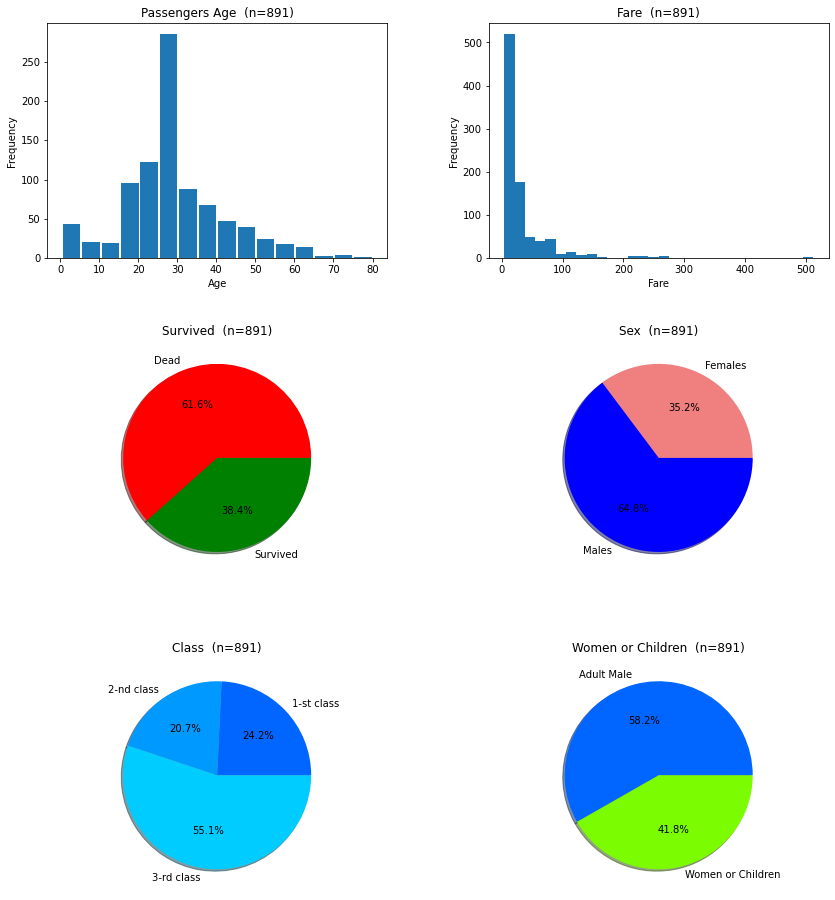

In [13]:
fig, axs = plt.subplots(3, 2, squeeze=False, figsize=(14, 16))
train_df.Age.plot.hist(bins=16, title='Passengers Age  '+'(n=891)', ax=axs[0, 0],rwidth=0.9) 
axs[0,0].set_xlabel("Age")

fare = train_df.Fare
fare.plot.hist(bins=30, title='Fare  '+'(n=891)', ax=axs[0,1],rwidth=1)
axs[0,1].set_xlabel("Fare")

col = ['red', 'green']
train_df.groupby('Survived').agg('count')['Age'].plot.pie(title='Survived  '+'(n=891)', ax=axs[1,0],labels=["Dead","Survived"],colors=col,autopct='%1.1f%%',shadow=True)
axs[1, 0].set_ylabel('')

col = ['lightcoral', 'blue']
train_df.groupby('Sex').agg('count')['Age'].plot.pie(title='Sex  '+'(n=891)', ax=axs[1, 1],labels=["Females","Males"],colors=col,autopct='%1.1f%%',shadow=True)
axs[1, 1].set_ylabel('')

col=["#0066ff","#0099ff","#00ccff"]
train_df.groupby('Pclass').agg('count')['Age'].plot.pie(title='Class  '+'(n=891)', ax=axs[2,0],labels=["1-st class","2-nd class", "3-rd class"],colors=col,autopct='%1.1f%%',shadow=True)
axs[2, 0].set_ylabel('')

col=["#0066ff","lawngreen"]
train_df.groupby('WomenOrChildren').agg('count')['Age'].plot.pie(title='Women or Children  '+'(n=891)', ax=axs[2,1],labels=["Adult Male","Women or Children"],colors=col,autopct='%1.1f%%',shadow=True)
axs[2, 1].set_ylabel('')

plt.subplots_adjust(wspace=0.3, hspace=0.35)

Clono il dataset di train X in W per aggiungere in W delle colonne utili per la descrizione dei dati

In [14]:
W=X
W['Survived']=y.values
# Uomini e donne sopravvissuti
W['Men survived']=np.zeros(W.shape[0])
W.loc[(W['Survived'] ==1) & (W['Sex']==1), 'Men survived'] = 1
W['Women survived']=np.zeros(W.shape[0])
W.loc[(W['Survived'] ==1) & (W['Sex']==0), 'Women survived'] = 1

total_men=np.round(sum(train_df['Sex']==1))
total_women=np.round(sum(train_df['Sex']==0))
men_survived=np.round(sum(W['Men survived']))
men_dead=total_men-men_survived
women_survived=np.round(sum(W['Women survived']))
women_dead=total_women-women_survived

**Persone sopravvissute per classi di viaggio**

In [15]:
W['First-Class survived']=np.zeros(W.shape[0])
W['Second-Class survived']=np.zeros(W.shape[0])
W['Third-Class survived']=np.zeros(W.shape[0])
W.loc[(W['Survived'] ==1) & (W['Pclass']==1), 'First-Class survived'] = 1
W.loc[(W['Survived'] ==1) & (W['Pclass']==2), 'Second-Class survived'] = 1
W.loc[(W['Survived'] ==1) & (W['Pclass']==3), 'Third-Class survived'] = 1
total_1st_class=sum(train_df['Pclass']==1)
total_2nd_class=sum(train_df['Pclass']==2)
total_3rd_class=sum(train_df['Pclass']==3)

first_class_survived=np.round(sum(W['First-Class survived']))
first_class_dead=total_1st_class-first_class_survived
second_class_survived=np.round(sum(W['Second-Class survived']))
second_class_dead=total_2nd_class-second_class_survived
third_class_survived=np.round(sum(W['Third-Class survived']))
third_class_dead=total_3rd_class-third_class_survived
third_class_survived

119.0

**Adulti e non adulti sopravvissuti**

In [16]:
W['Non-adult survived']=np.zeros(W.shape[0])
W['Adult survived']=np.zeros(W.shape[0])
W.loc[(W['Survived'] ==1) & (W['Age'] <18), 'Non-adult survived'] = 1
W.loc[(W['Survived'] ==1) & (W['Age']>=18), 'Adult survived'] = 1
total_non_adult=np.round(sum(train_df['Age'] <18))
total_adult=np.round(sum(train_df['Age']>=18))


non_adult_survived=np.round(sum(W['Non-adult survived']))
non_adult_dead=total_non_adult-non_adult_survived
adult_survived=np.round(sum(W['Adult survived']))
adult_dead=total_adult-adult_survived

**"Donne e Bambini" sopravvissuti**

In [17]:
W['WomenOrChildren survived']=np.zeros(W.shape[0])
W['Adult males survived']=np.zeros(W.shape[0])
W.loc[(W['Survived'] ==1) & (W['WomenOrChildren'] ==1), 'WomenOrChildren survived'] = 1
W.loc[(W['Survived'] ==1) & (W['WomenOrChildren'] ==0), 'Adult males survived'] = 1
total_WomenOrChildren=np.round(sum(train_df['WomenOrChildren']==1))
total_adult_males=np.round(sum(train_df['WomenOrChildren']==0))

WomenOrChildren_survived=sum(W['WomenOrChildren survived']==1)
WomenOrChildren_dead=total_WomenOrChildren-WomenOrChildren_survived
adult_males_survived=np.round(sum(W['Adult males survived']==1))
adult_males_dead=total_adult_males-adult_males_survived

**Costruzione del multiple bar chart**

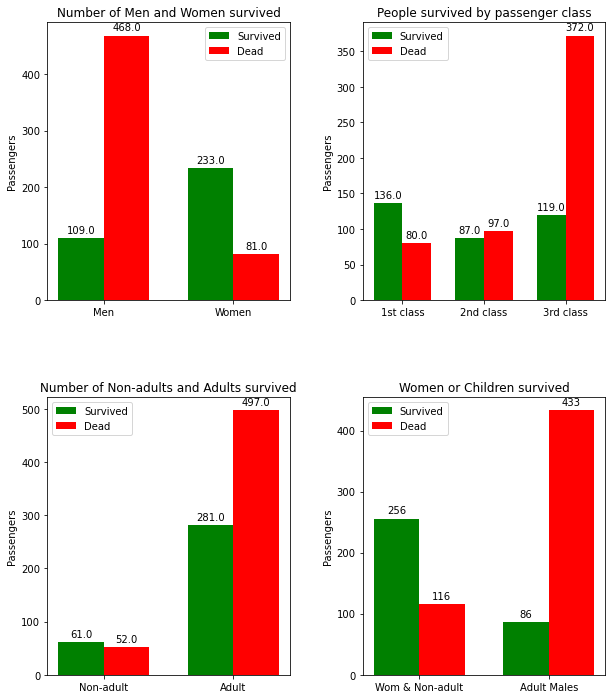

In [18]:
#LISTA DEI VALORI DELLE COLONNE DEL MULTIPLE BAR CHART

men_women_survived = [men_survived, women_survived]
men_women_dead = [men_dead, women_dead]

class_survived = [first_class_survived, second_class_survived, third_class_survived]
class_dead = [first_class_dead, second_class_dead, third_class_dead]

adultness_survived=[non_adult_survived,adult_survived]
adultness_dead=[non_adult_dead,adult_dead]

donnebambini_or_not_survived = [WomenOrChildren_survived,adult_males_survived]
donnebambini_or_not_dead = [WomenOrChildren_dead,adult_males_dead]

#FUNZIONE PER VISUALIZZARE I VALORI DELLE COLONNE DEL MULTIPLE BAR CHART SOPRA LE BARRE
# codice riadattatato da https://matplotlib.org/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
def autolabel(rects,ax): 
    """si aggiunge una label sopra ogni rettangolo, mostrando la sua altezza (che è il valore del rect)"""
    rect_list=[]
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # offset verticale di 3 punti
                    textcoords="offset points",
                    ha='center', va='bottom')

###
fig=plt.figure(figsize=(10,12))

# Uomini e Donne Sopravvissute
labels = ['Men', 'Women']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

ax = plt.subplot2grid((2,2),(0,0),rowspan=1,colspan=1)
rects1 = ax.bar(x - width/2, men_women_survived, width, label='Survived', color='green')
rects2 = ax.bar(x + width/2, men_women_dead, width, label='Dead', color='red')
ax.set_ylabel('Passengers')
ax.set_title('Number of Men and Women survived')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
autolabel(rects1,ax)
autolabel(rects2,ax)

# Persone Sopravvissute per classi di passeggero
labels = ['1st class', '2nd class','3rd class']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
ax1 = plt.subplot2grid((2,2),(0,1),rowspan=1,colspan=1)
rects1 = ax1.bar(x - width/2, class_survived, width, label='Survived', color='green')
rects2 = ax1.bar(x + width/2, class_dead, width, label='Dead', color='red')
ax1.set_ylabel('Passengers')
ax1.set_title('People survived by passenger class')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend()
autolabel(rects1,ax1)
autolabel(rects2,ax1)

# Bambini e Adulti Sopravvissuti
labels = ['Non-adult', 'Adult']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

ax2 = plt.subplot2grid((2,2),(1,0),rowspan=1,colspan=1)
rects1 = ax2.bar(x - width/2, adultness_survived, width, label='Survived', color='green')
rects2 = ax2.bar(x + width/2, adultness_dead, width, label='Dead', color='red')
ax2.set_ylabel('Passengers')
ax2.set_title('Number of Non-adults and Adults survived')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend()
autolabel(rects1,ax2)
autolabel(rects2,ax2)

# Donne&Bambini e AdultiMaschi Sopravvissuti
labels = ['Wom & Non-adult', 'Adult Males']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

ax3 = plt.subplot2grid((2,2),(1,1),rowspan=1,colspan=1)
rects1 = ax3.bar(x - width/2, donnebambini_or_not_survived, width, label='Survived', color='green')
rects2 = ax3.bar(x + width/2, donnebambini_or_not_dead, width, label='Dead', color='red')
ax3.set_ylabel('Passengers')
ax3.set_title('Women or Children survived')
ax3.set_xticks(x)
ax3.set_xticklabels(labels)
ax3.legend()
autolabel(rects1,ax3)
autolabel(rects2,ax3)

plt.subplots_adjust(wspace=0.3, hspace=0.35)

plt.show()

In [19]:
pass_class=train_df.groupby("Pclass")
pass_class

**RIDUZIONE DELLA DIMENSIONALITA' ATTRAVERSO LA STEPWISE BACKWARD REGRESSION**

Si è voluto verificare se i modelli forniscono migliori indici di accuracy di convalida, ricorrendo ad una riduzione del numero di caratteristiche.
Si è voluto utilizzare l'approccio della stepwise backward regression, utile per l'eliminazione delle variabili non significative. 
In questo caso la misura della significatività è data dal p-value. Maggiore è il p-value "P>|t|", minore è la statistica T (che è la standardizzazione dei coefficienti di regressione) e minore è la significatività della variabile. Assumendo la normalità delle variabili, e assumendo l'ipotesi nulla che le variabili siano indipendenti dalla Y, il p-value misura la probabilità di ottenere statistiche T uguali o meno probabili di quello osservato durante il test. Dunque, quanto più  T è grande (il coefficiente di regressione è grande rispetto alla sua deviazione standard), tanto minore sarà il p-value, e tanto minore sarà la plausibilità dell'ipotesi nulla di indipendenza
Una tipica soglia massima scelta per il p-value è 0.05, che corrisponde a una statistica T = 2 (in caso di perfetta normalità dei coefficienti di regressione corrisponde a 1.96)
L'algoritmo utilizzato scarta di volta in volta la variabile con il p-value più alto (ad eccezione dell'intercetta), fintanto che rimangono le sole variabili che presentano un p-value inferiore a 0.05. Per fare questo, una volta eliminata una variabile viene ristimato il modello di regressione
Le variabili rimaste sono significative, mentre il coefficiente delle variabili scartate viene considerato pari a 0. Un altro algoritmo di riduzione della dimensionalità è l'Analisi delle Componenti Principali (PCA), in cui dapprima vengono ortogonalizzate le diverse features, che quindi diventano tra loro indipendenti. Poi viene via via scelta la componente principale che è la variabile ortogonalizzata che presenta la massima varianza. Il PCA, tuttavia, non tiene conto della label, e si presta di più a casi di unsupervised learning. La selezione delle variabili basata sulla Stepwise backward regression riguarda direttamente la causalità tra le features e la variabile target, pertanto è un appropriato metodo di selezione delle variabili

In [20]:
#STEPWISE LINEAR REGRESSION

def stepwise_selection(X, y, 
                       initial_list=['Pclass', 'Sex','Age','Parch','Fare','Distance to NY','Fare per 1000km','Familiars','WomenOrChildren'], 
                       threshold_out = 0.05, 
                       verbose=True):
        
    included = list(initial_list)
    while True:
        changed=False
        

        # backward step
        # si istanzia un modello di regressione di tipo OLS (Ordinary Least Squares)
        model = sm.OLS(y, sm.add_constant(X[included])).fit()
        # si stampano i risultati del modello: coefficienti beta, statistiche T, p-value, R^2, adjusted R^2 ecc. All'inizio vengono prese in considerazione tutte le variabili
        print(model.summary()) 
        # si considerano i p-value di tutte le variabili tranne quello dell'intercetta, che comunque vogliamo mantenere
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # si identifica il massimo p-value (che è legato alla variabile meno significativa)
        if worst_pval > threshold_out: #threshold_out=0.05
            changed=True #il modello cambia. Quindi si deve compiere una nuova regressione
            worst_feature = pvalues.argmax() #si identifica la feature che ha il max p-value
            included.remove(included[worst_feature]) # si rimuove la caratteristica da quelle da includere nel modello di regressione
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed: 
            # se tutte le variabili soddisfano la soglia "threshold_out" non si deve più cambiare il modello e fare una nuova regressione. 
            #Si esce quindi dal ciclo con le sole variabili significative
            break
    return included

result_backward_stepwise_regression = stepwise_selection(X, y)
# Si stampano le sole variabili significative
print("\n\nVariabili significative (p-value<0.05): ",result_backward_stepwise_regression)

# elenco delle variabili significative
variables=result_backward_stepwise_regression







                            OLS Regression Results                            
Dep. Variable:               Survived   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     68.69
Date:                Sat, 11 Jul 2020   Prob (F-statistic):           1.42e-95
Time:                        19:33:38   Log-Likelihood:                -385.12
No. Observations:                 891   AIC:                             790.2
Df Residuals:                     881   BIC:                             838.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.4596      0.465     

**CONTROLLO SULL'IMPIEGO DI TUTTE LE VARIABILI O SOLO DELLE SIGNIFICATIVE**

Nel primo caso usa: 
full_variables=True

Nel secondo usa:
full_variables=False

In [21]:
full_variables=True

In [22]:
if full_variables==True:
    X=train_df[all_variables]   ####### ALL FEATURES X=train_df[all_variables]  ######### FEATURE SELECTION X=train_df[variables] 
else:
    X_te=test_df[variables] ####### ALL FEATURES X_te=test_df[all_variables]  ######### FEATURE SELECTION X_te=test_df[variables]

# Definizione del features_train set e del features_test set
features_train=X.values
features_test=X_te.values

#matrice delle features in cui vengono inclusi i datapoints di tutti i due datasets (train e test). La matrice è utile per la normalizzazione delle features
all_df_features=X_all_df.values

outliers detection

In [23]:
# Rimozione outliers nei dati secondo il modello IsolationForest
iso = IsolationForest(contamination=0.025, random_state=69)
yhat = iso.fit_predict(train_df)

train_df['Mask']=yhat  #se train_df['Mask']=1 l'esempio non è outlier, altrimenti lo è
train_df = train_df[train_df['Mask']==1]

# Definizione di features_train, SENZA GLI OUTLIERS
#### ALL FEATURES vs SELECTED FEATURES
if full_variables==True:
    features_train=train_df[all_variables] 
else:
    features_train=train_df[variables]
    
labels_train=train_df["Survived"]

**NORMALIZZAZIONE DELLE FEATURES** e rimozione outliers

Normalizzazione delle features, tenendo conto sia del train e del test datasets

In [24]:
# Istanzio un nuovo oggetto MinMaxScaler capace di normalizzare le caratteristiche



mms=MinMaxScaler()

# Definizione delle FEATURES su cui vogliamo effettuare la NORMALIZZAZIONE

#### ALL FEATURES vs SELECTED FEATURES
if full_variables==True:
    all_features_norm=mms.fit_transform(X_all_df)
else:
    all_features_norm=mms.fit_transform(X_all_df[['Pclass', 'Sex', 'Age', 'Familiars', 'WomenOrChildren']])

features_train_norm=all_features_norm[:891]
features_test_norm=all_features_norm[891:] # le colonne di features_test_norm dipendono dall'"if" precedente
labels_train_norm=y.values

#RIMOZIONE degli outliers sui dati NORMALIZZATI

#Definizione del DATASET in base alle FEATURES SELEZIONATE
#### ALL FEATURES vs SELECTED FEATURES
if full_variables==True:
    train_df_norm=pd.DataFrame(features_train_norm, columns=['Pclass','Sex','Age','Parch','Fare','Distance to NY','Fare per 1000km','Familiars','WomenOrChildren'])
else:
    train_df_norm=pd.DataFrame(features_train_norm, columns=['Pclass', 'Sex', 'Age', 'Familiars', 'WomenOrChildren'])
train_df_norm["Survived"]=labels_train_norm
yhat_norm = iso.fit_predict(train_df_norm)
train_df_norm['Mask']=yhat_norm  #se train_df['Mask']=1 l'esempio non è outlier, altrimenti lo è
train_df_norm = train_df_norm[train_df_norm['Mask']==1]

# DEFINIZIONE delle features_train_norm ossia delle variabili di ADDESTRAMENTO NORMALIZZATE
#### ALL FEATURES vs SELECTED FEATURES
if full_variables==True:
    features_train_norm=train_df_norm[all_variables]
else:
    features_train_norm=train_df_norm[variables]

     
labels_train_norm=train_df_norm["Survived"]

Per esempio mostro la normalizzazione delle features del dataset di addestramento. Per assicurare che a medesimi valori delle features corrispondano medesimi valori normalizzati è stato utilizzato il dataset all_df, sono stati calcolati i valori normalizzati, e poi è stato diviso nelle due parti relative ai dati di addestramento (fino alla riga 891) e ai dati di test (oltre la riga 891).
Le operazioni di normalizzazione sono necessarie nei modelli di classificazione basati sulle distanze tra i datapoints. Se due features hanno campi di variazione differenti dovuti alla scala, la componente delle distanze basata sulle caratteristiche avente un range più ampio risulterà indebitamente sopravvalutata, compromettendo l'affidabilità della classificazione. Tra i modelli impiegati in questo esercizio che sono influenzati dalla distanza troviamo: il Support Vector Machine e il K-Nearest Neighbors

**CREAZIONE FOLD DI CONVALIDA**

Nella cella seguente uso un oggetto Kfold, utile per la convalida incrociata dei classificatori e dei modelli di regressione. In questo caso si divide il train set in 10 parti, delle quali su 9 verrà addestrato un modello, di cui verrà valutata la validità in termini di accuracy sulla parte restante. La stessa operazione verrà compiuta cambiando la parte su cui il modello viene valutato, finché tutti i set di convalida non verranno utilizzati
Si usa shuffle=True per selezionare in modo casuale le 10 parti secondo un fisso random_state, che assicura i medesimi risultati in caso di ripetizione del codice

In [25]:
kf=KFold(10, shuffle=True, random_state=69) 

#10 sono le k divisioni del dataset; shuffle = True mescolo casualmente

**CLASSIFICATORI**
**SUPPORT VECTOR MACHINE**

L’idea principale che sta alla base di un algoritmo di Support Vector Machine è la massimizzazione del margine tra l'iperpiano di separazione e i punti appartenenti ad una certa classe (label) più vicini a questo iperpiano

In [26]:
validation_accuracies=[]
best_estimators=[]
#Definisco un dizionario dei parametri sui quali voglio calibrare il classificatore. In questo caso i parametri costituiscono la chiave, 
#i rispettivi valori sono invece le liste che a loro volta contengono i possibili valori su cui voglio addestrare il modello.
parameters = {'kernel':['rbf'],'C':[13500,14000,15000,16000], 'gamma': [0.075,0.08,0.085]}
#istanzio un classificatore di tipo support vector machine
clf=svm.SVC()
#creo un oggetto di tipo GridSearchCV che si concatena al clf definito in precedenza. é a tutti gli effetti un classificatore che viene addestrato su tutte le possibili
#combinazioni di parametri presenti all'interno del dizionario "parameters". 
#Si noti che questa operazione viene ripetuta su tutti i metodi di classificazione e regressione 
clf=GridSearchCV(clf,parameters,refit=True,cv=kf) 
#addestro l'insieme dei classificatori sulle features normalizzate in quanto altrimenti i classificatori considerano le distanze così come sono ignorando i diversi ranges delle variabili
# Prima del fitting è dunque necessario portare le features sulla stessa scala, utilizzando le features normalizzate
clf.fit(features_train_norm,labels_train_norm)
# stampo i parametri del migliore modello in fase di convalida, ossia i parametri del modello che garantiscono la migliore accuratezza media sui 10 KFold.
# questa operazione viene ripetuta su tutti i metodi di classificazione e regressione
print("Miglior classificatore Support Vector Machine ",clf.best_params_)
best_par=clf.best_params_ #recupero i parametri del migliore modello
df_perf_SVM=pd.DataFrame()
mean_accuracies=clf.cv_results_['mean_test_score'] #accuratezza media dei modelli di classificazione usati
parameters_tested=clf.cv_results_['params'] #parametri usati dai singoli modelli di classificazione
type_clf="svm.SVC"
# Voglio costruire un DataFrame per valutare le performances (df_perf_SVM['performances']) dei vari classificatori utilizzati in base a:
#df_perf_SVM['type']: cioé il tipo di classificatore
#df_perf_SVM['parameters']: cioé i parametri usati
#Ottenuti i risultati dei vari classificatori di tutti i tipi si costruirà un unico DataFrame che permetterà di confrontare le performances, e poi successivamente calcolare le previsioni dei classificatori selezionati
#Saranno selezionati i classificatori oltre una certa soglia di accuratezza in fase di convalida e i migliori di ogni tipologia
clf_type_list=[]
for i in range(len(parameters_tested)): #costruisco una lista lunga il numero di classificatori usati (cioé il numero di combinazioni dei parametri) che contiene altrettante stringhe uguali che indicano il tipo di classificatore
    clf_type_list.append(type_clf)
df_perf_SVM['type'] = clf_type_list
df_perf_SVM['parameters']=parameters_tested #l'utilizzo di un DataFrame che contenga la lista (o meglio il dizionario) di parametri usati, permette successivamente di recuperare facilmente i parametri, 
#per poi calcolare le previsioni
df_perf_SVM['performances']=mean_accuracies
df_perf_SVM
#definisco il modello di classificazione con i parametri del miglior modello, 
#così posso "fittarlo" e per infine calcolare il vettore di previsioni (418 * 1) della label, utilizzando le features del dataset di test (in questo caso normalizzate) 
best_clf_SVM=svm.SVC(kernel=best_par['kernel'],C=best_par['C'],gamma=best_par['gamma'])
best_clf_SVM.fit(features_train_norm,labels_train_norm) #fit del classificatore
#fitted_preds=best_clf_SVM.predict(features_train_norm) #previsione dentro il campione (non necessario)
preds_SVM=best_clf_SVM.predict(features_test_norm) #PREVISIONE della label "Survived" basandosi sulle FEATURES del dataset di TEST (in questo caso normalizzate)
#Costruzione di un DataFrame delle previsioni del miglior modello del tipo, e creazione di un file sottoponibile a Kaggle
results=pd.DataFrame({'PassengerId':test_df['PassengerId'], 'Survived':preds_SVM})
results.to_csv(r"Titanic_prediction_SVM.csv", index=False)

Miglior classificatore Support Vector Machine  {'C': 15000, 'gamma': 0.08, 'kernel': 'rbf'}


Nelle successive celle vengono ottenute le performances dei vari tipi di classificatori oltre a Support Vector Machine: Gaussian Naive Bayes,Decision Tree, Random Forest, K-Nearest Neighbor,e Logistic Regression. Siccome il procedimento è analogo al codice commentato dettagliatamente per il classificatore SVM, mi concentrerò maggiormente sugli aspetti statistici

#### Gaussian NB**
Le features"train_survived_ratio" e "train_deaths_ratio" sono le probabilità a priori delle labels (respectively "1" (life) and "0" (death)), P(label=0)=0.616 e P(label=1)=0.383. I valori di questi parametri possono leggermente migliorare la validation accuracy

In [27]:

train_deaths_ratio=1-np.mean(train_df["Survived"])
train_survived_ratio=np.mean(train_df["Survived"])
parameters = {'priors':[[0.5,0.5],[train_deaths_ratio,train_survived_ratio]],'var_smoothing': [1e-9,1e-8]}
clf=GaussianNB()
# istanziazione di una griglia di classificatori sulla base del dizionario dei parametri (parameters)
clf=GridSearchCV(clf,parameters,refit=True,cv=kf)
clf.fit(features_train,labels_train)
print("Miglior classificatore GaussianNB ",clf.best_params_)
best_par=clf.best_params_
df_perf_NB=pd.DataFrame() 
mean_accuracies=clf.cv_results_['mean_test_score']
parameters_tested=clf.cv_results_['params']
type_clf="GaussianNB"
clf_type_list=[]
for i in range(len(parameters_tested)):
    clf_type_list.append(type_clf)
#Costruzione DataFrame delle performance di accuratezza in fase di validazione
df_perf_NB['type'] = clf_type_list
df_perf_NB['parameters']=parameters_tested
df_perf_NB['performances']=mean_accuracies
#Dichiarazione del miglior classificatore (per accuratezza in fase di validazione)
best_clf_NB=GaussianNB(priors=best_par['priors'],var_smoothing=best_par['var_smoothing'])
best_clf_NB.fit(features_train,labels_train)
#Previsioni dataset di test
preds_NB=best_clf_NB.predict(features_test)
#Costruzione di un DataFrame delle previsioni del miglior modello del tipo, e creazione di un file sottoponibile a Kaggle
results=pd.DataFrame({'PassengerId':test_df['PassengerId'], 'Survived':preds_NB})
results.to_csv(r"Titanic_prediction_NB.csv", index=False)

Miglior classificatore GaussianNB  {'priors': [0.5, 0.5], 'var_smoothing': 1e-09}


**DECISION TREE**

Questo modello di classificazione è un sistema di suddivisione dei dati di addestramento, prendendo decisioni sulla base di una sequenza di domande. Ogni nodo (che contiene dati) viene ripartito in ulteriori nodi massimizzando l'Information Gain. Per ulteriori dettagli si consulti la relazione

In [28]:
parameters = {'max_depth':[7,8,10],'min_samples_split': [9,10,11,12],'min_samples_leaf':[1,2,3],'random_state':[69]}
clf=tree.DecisionTreeClassifier(criterion="gini")
# istanziazione di una griglia di classificatori sulla base del dizionario dei parametri (parameters)
clf=GridSearchCV(clf,parameters,refit=True,cv=kf)
clf.fit(features_train,labels_train)
print("Miglior classificatore Decision Tree ",clf.best_params_)
best_par_DT=clf.best_params_
df_perf_DT=pd.DataFrame() 
mean_accuracies=clf.cv_results_['mean_test_score']
parameters_tested=clf.cv_results_['params']
type_clf="tree.DecisionTreeClassifier"
clf_type_list=[]
for i in range(len(parameters_tested)):
    clf_type_list.append(type_clf)
#Costruzione DataFrame delle performance di accuratezza in fase di validazione
df_perf_DT['type'] = clf_type_list
df_perf_DT['parameters']=parameters_tested
df_perf_DT['performances']=mean_accuracies
#Dichiarazione del miglior classificatore (per accuratezza in fase di validazione)
best_clf_DT=tree.DecisionTreeClassifier(max_depth=best_par_DT['max_depth'],min_samples_split=best_par_DT['min_samples_split'],min_samples_leaf=best_par_DT['min_samples_leaf'])
best_clf_DT.fit(features_train,labels_train)

fitted_preds=best_clf_DT.predict(features_train)
#Previsioni dataset di test
preds_DT=best_clf_DT.predict(features_test)
#Costruzione di un DataFrame delle previsioni del miglior modello del tipo, e creazione di un file sottoponibile a Kaggle
results=pd.DataFrame({'PassengerId':test_df['PassengerId'], 'Survived':preds_DT})
results.to_csv(r"Titanic_prediction_DT.csv", index=False)

df_perf_DT

Miglior classificatore Decision Tree  {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 12, 'random_state': 69}


,type,parameters,performances
0,tree.DecisionTreeClassifier,"{'max_depth': 7, 'min_samples_leaf': 1, 'min_s...",0.815731
1,tree.DecisionTreeClassifier,"{'max_depth': 7, 'min_samples_leaf': 1, 'min_s...",0.815731
2,tree.DecisionTreeClassifier,"{'max_depth': 7, 'min_samples_leaf': 1, 'min_s...",0.816881
3,tree.DecisionTreeClassifier,"{'max_depth': 7, 'min_samples_leaf': 1, 'min_s...",0.816881
4,tree.DecisionTreeClassifier,"{'max_depth': 7, 'min_samples_leaf': 2, 'min_s...",0.807645
5,tree.DecisionTreeClassifier,"{'max_depth': 7, 'min_samples_leaf': 2, 'min_s...",0.808794
6,tree.DecisionTreeClassifier,"{'max_depth': 7, 'min_samples_leaf': 2, 'min_s...",0.811093
7,tree.DecisionTreeClassifier,"{'max_depth': 7, 'min_samples_leaf': 2, 'min_s...",0.811093
8,tree.DecisionTreeClassifier,"{'max_depth': 7, 'min_samples_leaf': 3, 'min_s...",0.808848
9,tree.DecisionTreeClassifier,"{'max_depth': 7, 'min_samples_leaf': 3, 'min_s...",0.808848


Codice utile per la rappresentazione grafica del Decision Tree ottimo

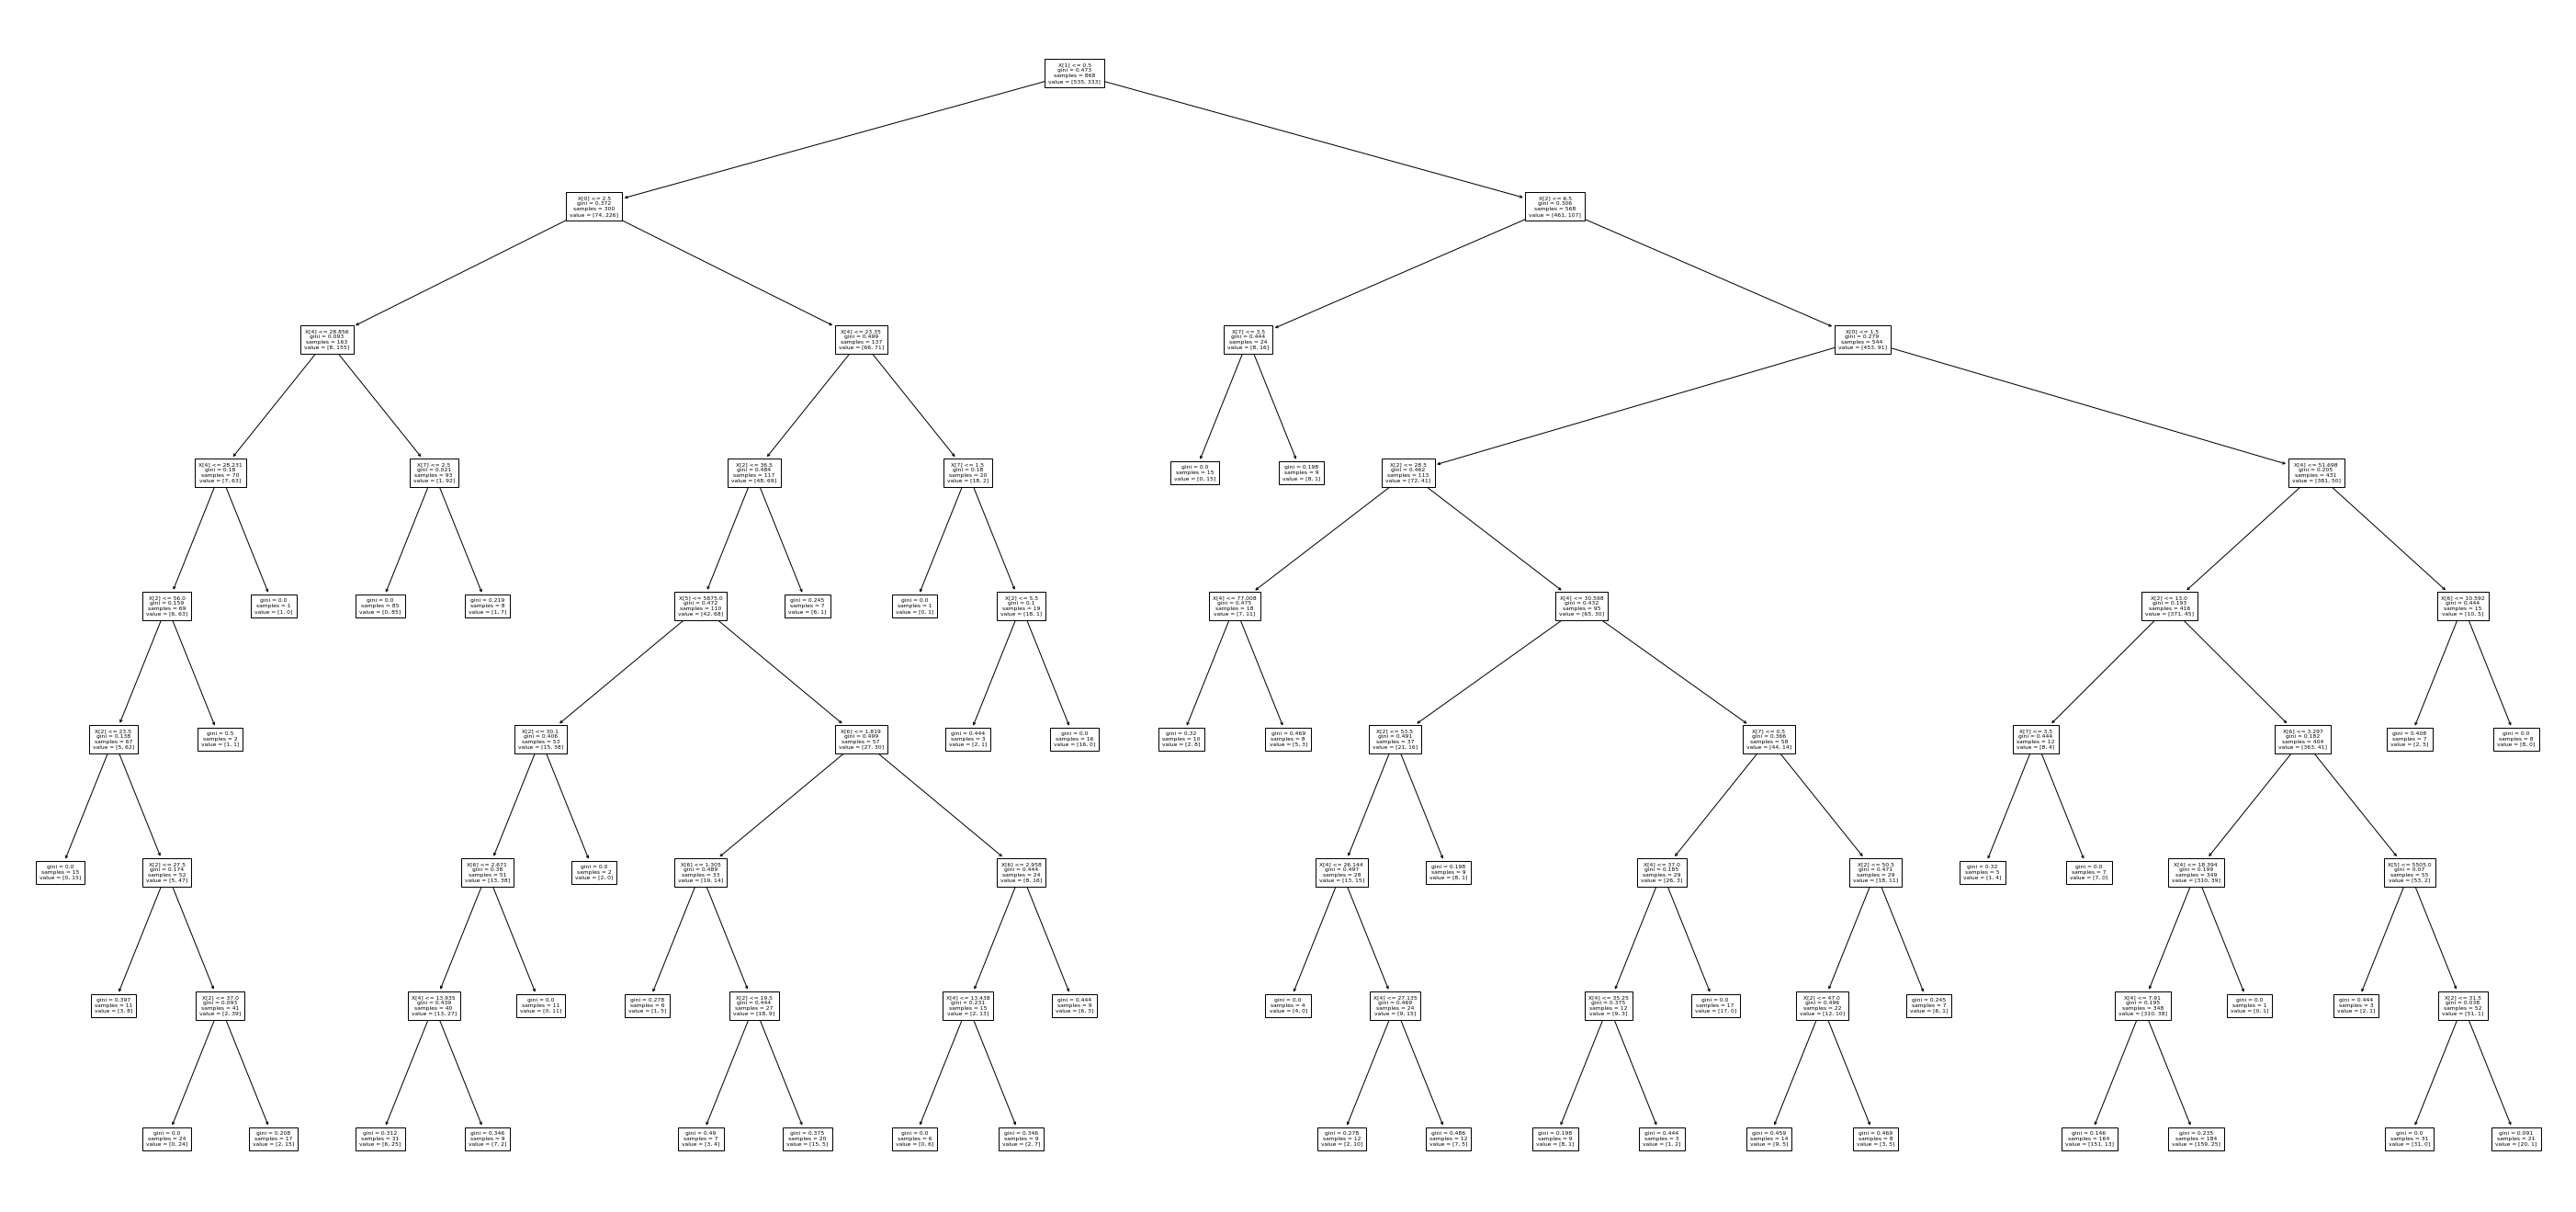

In [29]:
fig, ax = plt.subplots(figsize=(50, 24))
tree.plot_tree(best_clf_DT, fontsize=6)
plt.savefig('tree_high_dpi', dpi=100)
plt.show()

**RANDOM FOREST with optimized trees**

Il classificatore Random Forest è un esempio di ensemble method nel machine learning. Infatti, una foresta casuale può essere considerata come un insieme (ensemble) di alberi decisionali. In particolare il classificatore Random Forest, attraverso una votazione a maggioranza delle previsioni dei singoli alberi decisionali, calcola un vettore di previsioni. 

In [30]:
###RANDOM FOREST
# Per gli alberi della foresta si utilizzano i parametri ottimizzati degli alberi decisionali (Decision Tree).
#  Ho riscontrato che utilizzando i parametri ottimizzati si ottiene in fase di validazione un'accuratezza leggermente superiore (2-3% in più)
# n_estimators
parameters = {'n_estimators':[30,40,50,60],'max_features':[2,3,4,5],'n_jobs':[4],'max_depth':[best_par_DT['max_depth']],'min_samples_split':[best_par_DT['min_samples_split']],'min_samples_leaf':[best_par_DT['min_samples_leaf']],'random_state':[69]}
clf=RandomForestClassifier(criterion='gini')
# istanziazione di una griglia di classificatori sulla base del dizionario dei parametri (parameters)
clfRF=GridSearchCV(clf,parameters,refit=True,cv=kf)
clfRF.fit(features_train,labels_train)
print("Miglior classificatore Random Forest ",clfRF.best_params_)
best_par_RF=clfRF.best_params_
df_perf_RF=pd.DataFrame() 
mean_accuracies=clfRF.cv_results_['mean_test_score']
parameters_tested=clfRF.cv_results_['params']
type_clf="RandomForestClassifier"
clf_type_list=[]
for i in range(len(parameters_tested)):
    clf_type_list.append(type_clf)
#Costruzione DataFrame delle performance di accuratezza in fase di validazione
df_perf_RF['type'] = clf_type_list
df_perf_RF['parameters']=parameters_tested
df_perf_RF['performances']=mean_accuracies
#Dichiarazione del miglior classificatore (per accuratezza in fase di validazione)
best_clf_RF=RandomForestClassifier(n_estimators=best_par_RF['n_estimators'],max_features=best_par_RF['max_features'],max_depth=best_par_DT['max_depth'],min_samples_split=best_par_DT['min_samples_split'],min_samples_leaf=best_par_DT['min_samples_leaf'])

best_clf_RF.fit(features_train,labels_train)
fitted_preds=best_clf_RF.predict(features_train)
#Previsioni dataset di test
preds_RF=best_clf_RF.predict(features_test)
#Costruzione di un DataFrame delle previsioni del miglior modello del tipo, e creazione di un file sottoponibile a Kaggle
results=pd.DataFrame({'PassengerId':test_df['PassengerId'], 'Survived':preds_RF})
results.to_csv(r"Titanic_prediction_RF.csv", index=False)

df_perf_RF

Miglior classificatore Random Forest  {'max_depth': 8, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 60, 'n_jobs': 4, 'random_state': 69}


,type,parameters,performances
0,RandomForestClassifier,"{'max_depth': 8, 'max_features': 2, 'min_sampl...",0.830634
1,RandomForestClassifier,"{'max_depth': 8, 'max_features': 2, 'min_sampl...",0.829497
2,RandomForestClassifier,"{'max_depth': 8, 'max_features': 2, 'min_sampl...",0.834082
3,RandomForestClassifier,"{'max_depth': 8, 'max_features': 2, 'min_sampl...",0.826036
4,RandomForestClassifier,"{'max_depth': 8, 'max_features': 3, 'min_sampl...",0.831823
5,RandomForestClassifier,"{'max_depth': 8, 'max_features': 3, 'min_sampl...",0.836461
6,RandomForestClassifier,"{'max_depth': 8, 'max_features': 3, 'min_sampl...",0.838706
7,RandomForestClassifier,"{'max_depth': 8, 'max_features': 3, 'min_sampl...",0.837543
8,RandomForestClassifier,"{'max_depth': 8, 'max_features': 4, 'min_sampl...",0.837584
9,RandomForestClassifier,"{'max_depth': 8, 'max_features': 4, 'min_sampl...",0.837570


**K-NEAREST NEIGHBORS**

Questo metodo di classificazione consiste nell’assegnare ad un qualsiasi punto, in uno spazio vettoriale multidimensionale, avente coordinate x_1, x_2,..., x_m, la label prevalente di un certo numero k di train datapoints vicini. 

In [31]:
parameters={'n_neighbors':[5,15,21,20,25,30,31,35,41],'weights': ['uniform']}
clf=KNeighborsClassifier()
# istanziazione di una griglia di classificatori sulla base del dizionario dei parametri (parameters)
clf=GridSearchCV(clf,parameters,refit=True,cv=kf)
clf.fit(features_train_norm,labels_train_norm)
print("Miglior classificatore KNeighborsClassifier ",clf.best_params_)
best_par=clf.best_params_
df_perf_KNN=pd.DataFrame() 
mean_accuracies=clf.cv_results_['mean_test_score']
parameters_tested=clf.cv_results_['params']
type_clf="KNeighborsClassifier"
clf_type_list=[]
for i in range(len(parameters_tested)):
    clf_type_list.append(type_clf)
#Costruzione DataFrame delle performance di accuratezza in fase di validazione
df_perf_KNN['type'] = clf_type_list
df_perf_KNN['parameters']=parameters_tested
df_perf_KNN['performances']=mean_accuracies
#Dichiarazione del miglior classificatore (per accuratezza in fase di validazione)
best_clf=KNeighborsClassifier(n_neighbors=best_par['n_neighbors'],weights=best_par['weights'])
best_clf.fit(features_train_norm,labels_train_norm)
#Previsioni dataset di test
preds_KNN=best_clf.predict(features_test_norm)
#Costruzione di un DataFrame delle previsioni del miglior modello del tipo, e creazione di un file sottoponibile a Kaggle
results=pd.DataFrame({'PassengerId':test_df['PassengerId'], 'Survived':preds_KNN})
results.to_csv(r"Titanic_prediction_KNN.csv", index=False)

df_perf_KNN

Miglior classificatore KNeighborsClassifier  {'n_neighbors': 31, 'weights': 'uniform'}


,type,parameters,performances
0,KNeighborsClassifier,"{'n_neighbors': 5, 'weights': 'uniform'}",0.821411
1,KNeighborsClassifier,"{'n_neighbors': 15, 'weights': 'uniform'}",0.813406
2,KNeighborsClassifier,"{'n_neighbors': 21, 'weights': 'uniform'}",0.805306
3,KNeighborsClassifier,"{'n_neighbors': 20, 'weights': 'uniform'}",0.812216
4,KNeighborsClassifier,"{'n_neighbors': 25, 'weights': 'uniform'}",0.811067
5,KNeighborsClassifier,"{'n_neighbors': 30, 'weights': 'uniform'}",0.819113
6,KNeighborsClassifier,"{'n_neighbors': 31, 'weights': 'uniform'}",0.821425
7,KNeighborsClassifier,"{'n_neighbors': 35, 'weights': 'uniform'}",0.815678
8,KNeighborsClassifier,"{'n_neighbors': 41, 'weights': 'uniform'}",0.809890


**LOGISTIC REGRESSION.**
Viene usata la Penalty L2

Con questo modello di regressione, la cui variabile dipendente è limitata asintoticamente tra 0 e 1, è possibile prevedere valori della label binari ("0" oppure "1")

In [32]:
parameters={'C':[10,7.5,6,5,4,3,1,0.5],'solver': ['lbfgs'],'max_iter':[200]}
clf = LogisticRegression()
# istanziazione di una griglia di classificatori sulla base del dizionario dei parametri (parameters)
clf=GridSearchCV(clf,parameters,refit=True,cv=kf)
clf.fit(features_train_norm,labels_train_norm)
print("Miglior classificatore LogisticRegression ",clf.best_params_)
best_par=clf.best_params_
df_perf_LogReg=pd.DataFrame() 
mean_accuracies=clf.cv_results_['mean_test_score']
parameters_tested=clf.cv_results_['params']
type_clf="LogisticRegression"
clf_type_list=[]
for i in range(len(parameters_tested)):
    clf_type_list.append(type_clf)
#Costruzione DataFrame delle performance di accuratezza in fase di validazione
df_perf_LogReg['type'] = clf_type_list
df_perf_LogReg['parameters']=parameters_tested
df_perf_LogReg['performances']=mean_accuracies
#Dichiarazione del miglior classificatore (per accuratezza in fase di validazione)
best_clf=LogisticRegression(C=best_par['C'])
best_clf.fit(features_train_norm,labels_train_norm)
acc=accuracy_score(fitted_preds,labels_train_norm)
#Previsioni dataset di test
preds_LogReg=best_clf.predict(features_test_norm)
#Costruzione di un DataFrame delle previsioni del miglior modello del tipo, e creazione di un file sottoponibile a Kaggle
results=pd.DataFrame({'PassengerId':test_df['PassengerId'], 'Survived':preds_LogReg})
results.to_csv(r"Titanic_prediction_LogReg.csv", index=False)

df_perf_LogReg

Miglior classificatore LogisticRegression  {'C': 7.5, 'max_iter': 200, 'solver': 'lbfgs'}


,type,parameters,performances
0,LogisticRegression,"{'C': 10, 'max_iter': 200, 'solver': 'lbfgs'}",0.811026
1,LogisticRegression,"{'C': 7.5, 'max_iter': 200, 'solver': 'lbfgs'}",0.813339
2,LogisticRegression,"{'C': 6, 'max_iter': 200, 'solver': 'lbfgs'}",0.813339
3,LogisticRegression,"{'C': 5, 'max_iter': 200, 'solver': 'lbfgs'}",0.813339
4,LogisticRegression,"{'C': 4, 'max_iter': 200, 'solver': 'lbfgs'}",0.813339
5,LogisticRegression,"{'C': 3, 'max_iter': 200, 'solver': 'lbfgs'}",0.812189
6,LogisticRegression,"{'C': 1, 'max_iter': 200, 'solver': 'lbfgs'}",0.813312
7,LogisticRegression,"{'C': 0.5, 'max_iter': 200, 'solver': 'lbfgs'}",0.811013


Concateno i DataFrame dei classificatori utilizzati fino a qui, per confrontare le performances dei classificatori

In [33]:
df_perf_all=pd.concat([df_perf_NB,df_perf_SVM,df_perf_DT,df_perf_RF,df_perf_KNN,df_perf_LogReg])

La lista index_df_perf_all , costruita con il ciclo for contiene un range di numeri interi da 0 fino al numero totale di modelli in df_perf_all.
Questa lista viene inserita come indice, in modo che ogni classificatore abbia un indice unico (attraverso l'istruzione df_perf_all.set_index(df_perf_all['new index']))

In [34]:
index_df_perf_all=[]
for it in range(df_perf_all.shape[0]):
    index_df_perf_all.append(it)
df_perf_all['new index']=index_df_perf_all
df_perf_all=df_perf_all.set_index(df_perf_all['new index'])
df_perf_all = df_perf_all.drop('new index', 1)

In [35]:
# Si selezionano i classificatori con un'accuratezza di convalida superiore a una certa soglia
df_perf_eligible=df_perf_all.loc[(df_perf_all['performances'] > 0.834)]
df_perf_eligible

,type,parameters,performances
new index,,,
4,svm.SVC,"{'C': 13500, 'gamma': 0.075, 'kernel': 'rbf'}",0.834122
5,svm.SVC,"{'C': 13500, 'gamma': 0.08, 'kernel': 'rbf'}",0.834122
6,svm.SVC,"{'C': 13500, 'gamma': 0.085, 'kernel': 'rbf'}",0.834122
7,svm.SVC,"{'C': 14000, 'gamma': 0.075, 'kernel': 'rbf'}",0.834122
8,svm.SVC,"{'C': 14000, 'gamma': 0.08, 'kernel': 'rbf'}",0.834122
9,svm.SVC,"{'C': 14000, 'gamma': 0.085, 'kernel': 'rbf'}",0.834109
11,svm.SVC,"{'C': 15000, 'gamma': 0.08, 'kernel': 'rbf'}",0.835271
12,svm.SVC,"{'C': 15000, 'gamma': 0.085, 'kernel': 'rbf'}",0.834109
13,svm.SVC,"{'C': 16000, 'gamma': 0.075, 'kernel': 'rbf'}",0.834122


In [36]:
# Si selezionano i migliori classificatori di ogni tipo
df_perf_group_best=df_perf_all.loc[df_perf_all.groupby('type').performances.idxmax()]
df_perf_group_best

,type,parameters,performances
new index,,,
0,GaussianNB,"{'priors': [0.5, 0.5], 'var_smoothing': 1e-09}",0.784483
74,KNeighborsClassifier,"{'n_neighbors': 31, 'weights': 'uniform'}",0.821425
78,LogisticRegression,"{'C': 7.5, 'max_iter': 200, 'solver': 'lbfgs'}",0.813339
67,RandomForestClassifier,"{'max_depth': 8, 'max_features': 5, 'min_sampl...",0.849105
11,svm.SVC,"{'C': 15000, 'gamma': 0.08, 'kernel': 'rbf'}",0.835271
31,tree.DecisionTreeClassifier,"{'max_depth': 8, 'min_samples_leaf': 1, 'min_s...",0.827292


Si uniscono i due DataFrame precedenti, rimuovendo i duplicati. Così si ottengono i classificatori che ho ritenuto idonei a esprimere previsioni
Come esempio di applicazione di un ensemble method, l'intenzione è quella di calcolare una media (ponderata) dei punteggi, tendendo conto di tutti i classificatori idonei.
Così si potrebbe ottenere un meta-classificatore che potrebbe garantire una predizione più accurata e consistente.
L'idea che qui si vuole implementare è simile al majority voting, in cui la predizione più frequente dei classificatori per un datapoint risulterà quella assunta dal meta-classificatore.
Più in dettaglio, però, si è scelto di assegnare diversi pesi ai classificatori votanti, basati sulla loro accuratezza in fase di convalida

In [37]:
# Si uniscono i dataframes e si rimuovono i duplicati
df_perf_voting=pd.concat([df_perf_eligible,df_perf_group_best])
df_perf_voting = df_perf_voting.reset_index()
df_perf_voting=df_perf_voting.drop_duplicates(subset='new index')
# Versione finale dei classificatori votanti
df_perf_voting

,new index,type,parameters,performances
0,4,svm.SVC,"{'C': 13500, 'gamma': 0.075, 'kernel': 'rbf'}",0.834122
1,5,svm.SVC,"{'C': 13500, 'gamma': 0.08, 'kernel': 'rbf'}",0.834122
2,6,svm.SVC,"{'C': 13500, 'gamma': 0.085, 'kernel': 'rbf'}",0.834122
3,7,svm.SVC,"{'C': 14000, 'gamma': 0.075, 'kernel': 'rbf'}",0.834122
4,8,svm.SVC,"{'C': 14000, 'gamma': 0.08, 'kernel': 'rbf'}",0.834122
5,9,svm.SVC,"{'C': 14000, 'gamma': 0.085, 'kernel': 'rbf'}",0.834109
6,11,svm.SVC,"{'C': 15000, 'gamma': 0.08, 'kernel': 'rbf'}",0.835271
7,12,svm.SVC,"{'C': 15000, 'gamma': 0.085, 'kernel': 'rbf'}",0.834109
8,13,svm.SVC,"{'C': 16000, 'gamma': 0.075, 'kernel': 'rbf'}",0.834122
9,14,svm.SVC,"{'C': 16000, 'gamma': 0.08, 'kernel': 'rbf'}",0.835271


Assegnazione pesi ai classificatori

In [38]:
# si calcola, come somma totale dei pesi, la somma delle statistiche di accuratezza in fase di convalida
sum_weights=sum(df_perf_voting['performances'])
# il peso "elettorale" di ogni classificatore è dato dal rapporto tra la sua accuratezza e la somma dei pesi. Così facendo,
# si attribuisce una maggiore importanza ai classificatori più performanti 
df_perf_voting['weights']=df_perf_voting['performances']/sum_weights
df_perf_voting=df_perf_voting.sort_values(['type', 'performances'], ascending=[True, False])
index_df_perf_voting=[]
# con le righe seguenti si riaggiorna in modo incrementalel'indice
for it in range(df_perf_voting.shape[0]):
    index_df_perf_voting.append(it)
df_perf_voting['new index']=index_df_perf_voting
df_perf_voting=df_perf_voting.set_index(df_perf_voting['new index'])
df_perf_voting = df_perf_voting.drop('new index', 1)
df_perf_voting

,type,parameters,performances,weights
new index,,,,
0,GaussianNB,"{'priors': [0.5, 0.5], 'var_smoothing': 1e-09}",0.784483,0.036211
1,KNeighborsClassifier,"{'n_neighbors': 31, 'weights': 'uniform'}",0.821425,0.037917
2,LogisticRegression,"{'C': 7.5, 'max_iter': 200, 'solver': 'lbfgs'}",0.813339,0.037543
3,RandomForestClassifier,"{'max_depth': 8, 'max_features': 5, 'min_sampl...",0.849105,0.039194
4,RandomForestClassifier,"{'max_depth': 8, 'max_features': 5, 'min_sampl...",0.845630,0.039034
5,RandomForestClassifier,"{'max_depth': 8, 'max_features': 5, 'min_sampl...",0.843344,0.038929
6,RandomForestClassifier,"{'max_depth': 8, 'max_features': 5, 'min_sampl...",0.842195,0.038875
7,RandomForestClassifier,"{'max_depth': 8, 'max_features': 3, 'min_sampl...",0.838706,0.038714
8,RandomForestClassifier,"{'max_depth': 8, 'max_features': 4, 'min_sampl...",0.837584,0.038663


Con la cella seguente si ottengono i vettori di previsione per ognuno dei classificatori votanti

In [39]:
# Trasformo il DataFrame precedente in un dictionary per poter recuperare il tipo di classificatore, e i parametri di ogni singolo classificatore votante
dict_clf_voting=df_perf_voting.to_dict('index')
# predictions_vectors è la lista che verrà riempita dai vettori di previsione di ogni singolo classificatore (o modello di regressione)
predictions_vectors=[]
# per ogni elemento del dizionario l'obiettivo è ottenere il vettore di previsioni.
# dato che ogni tipo di classificatore si basa su diversi parametri, bisogna prima specificare il tipo di classificatore utilizzato. 
# Per questo all'interno del ciclo for, è stata approntata una "struttura" ad "if"
for item in dict_clf_voting:
    if dict_clf_voting[item]['type']=="GaussianNB": #per esempio se il tipo di classificatore di un certo item è Gaussian Naive Bayes...
        #... si istanzia un classificatore con il valore specifico di item del parametro 'prior' e poi di 'var_smoothing'
        clf=GaussianNB(priors=dict_clf_voting[item]['parameters']['priors'],var_smoothing=dict_clf_voting[item]['parameters']['var_smoothing'])
        clf.fit(features_train,labels_train) # si addestra sul train set questo specifico classificatore
        preds_NB=clf.predict(features_test) # infine si calcolano le previsioni del dataset di test.
        predictions_vectors.append(preds_NB) # Si aggiunge il vettore delle previsioni alla lista "predictions_vectors", che si popola scorrendo il ciclo for di dict_clf_voting
        # si ripetono queste operazioni anche per gli altri tipi di classificatori, prestando attenzione alla necessità di normalizzare le features per gli algoritmi "KNeighborsClassifier"
        # e "svm.SVC" (Support Vector Machine). Infatti, questi si basano sulle distanze tra i datapoints, e pertanto risentono (se non normalizzati o standardizzati) di feature che hanno differenti unità di misura e campo di variazione
    if dict_clf_voting[item]['type']=="KNeighborsClassifier":
        clf=KNeighborsClassifier(n_neighbors=dict_clf_voting[item]['parameters']['n_neighbors'],weights=dict_clf_voting[item]['parameters']['weights'])
        clf.fit(features_train_norm,labels_train_norm)
        preds_KNN=clf.predict(features_test_norm)
        predictions_vectors.append(preds_KNN)
    if dict_clf_voting[item]['type']=="LogisticRegression":
        clf=LogisticRegression(C=dict_clf_voting[item]['parameters']['C'],solver=dict_clf_voting[item]['parameters']['solver'])
        clf.fit(features_train_norm,labels_train_norm)
        preds_KNN=clf.predict(features_test_norm)
        predictions_vectors.append(preds_KNN)
    if dict_clf_voting[item]['type']=="RandomForestClassifier":
        clf=RandomForestClassifier(n_estimators=dict_clf_voting[item]['parameters']['n_estimators'],max_features=dict_clf_voting[item]['parameters']['max_features'],max_depth=dict_clf_voting[item]['parameters']['max_depth'],min_samples_split=dict_clf_voting[item]['parameters']['min_samples_split'],min_samples_leaf=dict_clf_voting[item]['parameters']['min_samples_leaf'])
        clf.fit(features_train,labels_train)
        preds_RF=clf.predict(features_test)
        predictions_vectors.append(preds_RF)
    if dict_clf_voting[item]['type']=="svm.SVC":
        clf=svm.SVC(C=dict_clf_voting[item]['parameters']['C'],gamma=dict_clf_voting[item]['parameters']['gamma'],kernel=dict_clf_voting[item]['parameters']['kernel'])
        clf.fit(features_train_norm,labels_train_norm)
        preds_SVM=clf.predict(features_test_norm)
        predictions_vectors.append(preds_SVM)
    if dict_clf_voting[item]['type']=="tree.DecisionTreeClassifier":
        clf=tree.DecisionTreeClassifier(max_depth=dict_clf_voting[item]['parameters']['max_depth'],min_samples_split=dict_clf_voting[item]['parameters']['min_samples_split'],min_samples_leaf=dict_clf_voting[item]['parameters']['min_samples_leaf'])
        clf.fit(features_train,labels_train)
        preds_DT=clf.predict(features_test)
        predictions_vectors.append(preds_DT)

Si trasforma la lista dei singoli vettori (418 * 1) di previsione (della sopravvivenza delle persone nel dataset di test) in una matrice.
Facendo il prodotto vettoriale tra i pesi e la matrice delle previsioni, si ottiene il vettore ensemble delle previsioni che è una media ponderata delle previsioni dei singoli classificatori. Il vettore risultante si chiama votes_float
Dopodiché, è necessario arrotondare votes_float in un numero intero per ottenere i valori binari "0" e "1". Perché il vettore sia letto correttamente da kaggle infine è necessario convertirlo in maniera esplicita in interi tramite votes=np.round(votes_float,0).astype(int)
votes è il vettore che esprime definitivamente le previsioni sul data set di test

In [40]:
#trasformazione della lista dei vettori in una matrice
prediction_matrix=np.array(predictions_vectors)
#estrazione dei pesi e trasposizione per il successivo prodotto vettoriale
weights=np.array(df_perf_voting['weights']).T
#prodotto vettoriale tra i pesi e la matrice delle previsioni
votes_float=np.dot(weights,prediction_matrix)
votes_float_df=pd.DataFrame({'PassengerId':test_df['PassengerId'], 'Survived':votes_float})
#arrotondamento del vettore ottenuto e conversione in tipi interi
votes=np.round(votes_float,0).astype(int)
results=pd.DataFrame({'PassengerId':test_df['PassengerId'], 'Survived':votes})
results.to_csv(r"Titanic_prediction_ENSEMBLE.csv", index=False)
print("Elections done")

Elections done


In [41]:
votes_float_df

,PassengerId,Survived
0,892,0.000000
1,893,0.229573
2,894,0.000000
3,895,0.000000
4,896,0.538288
...,...,...
413,1305,0.000000
414,1306,1.000000
415,1307,0.000000
416,1308,0.000000


In [42]:
results

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
